# Snow Depth Analysis
### Purpose
This notebook will look at volunteer trends for reporting snow depth, adressing the Github issue #54  
(this notebook is a copy of the rain and snow analysis notebooks, but for snow depths)

### Author: 
Hamza El-Saawy
### Date: 
2020-09-14
### Update Date: 
2020-09-14

### Inputs 
 - `1.3-rec-connecting-fips-ecosystem-data.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC ecological data 
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
n/a

## Notes
While the snow notebook looked only at snowfall(`am/pm_snow` for volunteers and `snow` for GHCN), this notebook looks at (`min/max_snow` for volunteers and `snwd` for GHCN).
Snowdepth measurements methods are likely highly variable from location to location and year to year, so this notebook simply discretizes the problem to see if any snow was on the ground during the observation period.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.stats as stats

In [3]:
import sklearn.metrics as metrics

In [4]:
sns.set(style="darkgrid")

In [5]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

In [6]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a snow value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [7]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [8]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t", compression = "gzip")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'ui','country_state', 'c_id', 'c_lat', 'c_lon',
                              'min_snow', 'max_snow', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','snwd',
                             ]]

In [10]:
# Observe the Size of the data frame
prcp_data.shape

(756378, 19)

In [11]:
# Observe the number of unique circles in the dataframe 
prcp_data['ui'].nunique()

80765

In [12]:
prcp_data.head()

,count_date,c_name,ui,country_state,c_id,c_lat,c_lon,min_snow,max_snow,c_elev,c_ecosys,c_nlcdcode,s_id,s_lat,s_lon,s_elev,s_ecosys,s_nlcdcode,snwd
0,1955-01-01,Hawai'i: Volcano N.P.,19.4333-155.2833_1955,US-HI,8e3wd3w,19.4333,-155.2833,NaN,NaN,1228.18,NaN,NaN,USC00511303,19.4297,-155.2561,1210.40,NaN,NaN,0.0
1,1955-12-31,Hawai'i: Volcano N.P.,19.4333-155.2833_1956,US-HI,8e3wd3w,19.4333,-155.2833,NaN,NaN,1228.18,NaN,NaN,USC00511303,19.4297,-155.2561,1210.40,NaN,NaN,0.0
2,1967-12-30,Hawai'i: Volcano N.P.,19.4333-155.2833_1968,US-HI,8e3wd3w,19.4333,-155.2833,0.0,0.0,1228.18,NaN,NaN,US1HIHI0013,19.4391,-155.2156,1059.20,NaN,NaN,NaN
3,1967-12-30,Hawai'i: Volcano N.P.,19.4333-155.2833_1968,US-HI,8e3wd3w,19.4333,-155.2833,0.0,0.0,1228.18,NaN,NaN,US1HIHI0071,19.4414,-155.2487,1194.80,NaN,NaN,NaN
4,1967-12-30,Hawai'i: Volcano N.P.,19.4333-155.2833_1968,US-HI,8e3wd3w,19.4333,-155.2833,0.0,0.0,1228.18,NaN,NaN,USC00514563,19.4094,-155.2608,1079.87,NaN,NaN,NaN


## Data Prep

#### Stations Reporting Snow

In [13]:
# Create the field s_snwd which is True if the row (station) has a value of snwd 
# greater than 0 (an indicator that snow did accumulate) and is NA otherwise

# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snwd'] = np.where(prcp_data.snwd.isna(), pd.NA, prcp_data.snwd > 0)
prcp_data['s_snwd'] = prcp_data.s_snwd.astype('boolean')

#### Volunteer records on snow data

how clean are min_snow and max_snow in relation to each other?

In [14]:
# how many cases are there where min snowdepth is greater than max snowdepth?
sum(prcp_data.min_snow > prcp_data.max_snow)

17

In [15]:
# how many cases are there where min snowdepth > 0, but max snowdepth = 0?
((prcp_data.min_snow > 0) & (prcp_data.max_snow == 0)).sum()

1

In [16]:
# how many cases are there where min snowdepth > 0, but max snowdepth is NA?
((prcp_data.min_snow > 0) & (prcp_data.max_snow.isna())).sum()

270

In [17]:
# how many cases are there where min snowdepth > 0, but max snowdepth is NA?
# (if min snow is na, one would want to assume there was no snowfall at all, but that seems to not be the case)
((prcp_data.min_snow.isna()) & (prcp_data.max_snow > 0)).sum()

3097

In [18]:
# based on the above, lets assume there was snow (according to the volunteers) if either [min|max]_snow > 0
# since we cant support `max_snow == 0 or na --> min_snow == 0`
prcp_data['c_snwd'] = np.where((prcp_data.min_snow.isna() & prcp_data.min_snow.isna()), pd.NA, ((prcp_data.min_snow > 0) | (prcp_data.max_snow > 0)))

## Comparing stations and circles
1. Calulate the distance between the station and the circle. Field is 'distance' 
2. Calulate the absolute change in elivation between the station and the circle. Field is 'd_elev'
3. Calulate if station and circle share ecosystem. Fields 'same_ecosys' and 'same_nlcd'

In [22]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [23]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [24]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## Apply Data Limits on Elevation and Distance and Prep for Analysis 
1. Drop rows where the circle and the station are too far away from each other in either distance or elivation
2. Remove columns we dont need
3. Sort the dataset by circle then station

In [25]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [26]:
# once again dump excess data
prcp_data.drop(columns=['min_snow', 'max_snow','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','snwd',], inplace=True)

In [27]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'ui','country_state', 
                        'c_id', 'c_lat', 'c_lon','c_snwd']].groupby(['c_id', 'count_date']).agg('first')

In [28]:
# isolate only the circle specific volunteer data
circle_obs.head(30)

c_name                                 ui  \
c_id    count_date                                                       
87ymwsn 1968-12-26   Kaua'i: Waimea              22.0833-159.6667_1969   
87ysunb 1971-12-27   Kaua'i: Lihu'e              21.9667-159.4333_1972   
        1972-12-17   Kaua'i: Lihu'e              21.9667-159.4333_1973   
        1973-12-16   Kaua'i: Lihu'e              21.9667-159.4333_1974   
        1974-12-15   Kaua'i: Lihu'e              21.9667-159.4333_1975   
        1976-01-04   Kaua'i: Lihu'e              21.9667-159.4333_1976   
        1976-12-18   Kaua'i: Lihu'e              21.9667-159.4333_1977   
        1977-12-17   Kaua'i: Lihu'e              21.9667-159.4333_1978   
        1978-12-16   Kaua'i: Lihu'e              21.9667-159.4333_1979   
        1979-12-15   Kaua'i: Lihu'e              21.9667-159.4333_1980   
        1980-12-20   Kaua'i: Lihu'e              21.9667-159.4333_1981   
        1981-12-19   Kaua'i: Lihu'e              21.9667-159.4333_1982   
        1982-12-18   Kaua'i: Lihu'e              21.9667-159.4333_1983   
        1983-12-17   Kaua'i: Lihu'e              21.9667-159.4333_1984   
        1984-12-15   Kaua'i: Lihu'e              21.9667-159.4333_1985   
        1985-12-21   Kaua'i: Lihu'e              21.9667-159.4333_1986   
        1986-12-20   Kaua'i: Lihu'e              21.9667-159.4333_1987   
        1987-12-19   Kaua'i: Lihu'e              21.9667-159.4333_1988   
        1988-12-17   Kaua'i: Lihu'e              21.9667-159.4333_1989   
        1989-12-16   Kaua'i: Lihu'e              21.9667-159.4333_1990   
        1990-12-15   Kaua'i: Lihu'e              21.9667-159.4333_1991   
        1992-12-19   Kaua'i: Lihu'e              21.9667-159.4333_1993   
87zc96n 1939-12-24  O'ahu: Honolulu  21.369211-157.78739099999999_1940   
        1940-12-22  O'ahu: Honolulu  21.369211-157.78739099999999_1941   
        1944-12-17  O'ahu: Honolulu  21.369211-157.78739099999999_1945   
        1945-12-23  O'ahu: Honolulu  21.369211-157.78739099999999_1946   
        1946-12-29  O'ahu: Honolulu  21.369211-157.78739099999999_1947   
        1947-12-21  O'ahu: Honolulu  21.369211-157.78739099999999_1948   
        1948-12-26  O'ahu: Honolulu  21.369211-157.78739099999999_1949   
        1949-12-26  O'ahu: Honolulu  21.369211-157.78739099999999_1950   

                   country_state      c_lat       c_lon c_snwd  
c_id    count_date                                              
87ymwsn 1968-12-26         US-HI  22.083300 -159.666700  False  
87ysunb 1971-12-27         US-HI  21.966700 -159.433300  False  
        1972-12-17         US-HI  21.966700 -159.433300  False  
        1973-12-16         US-HI  21.966700 -159.433300  False  
        1974-12-15         US-HI  21.966700 -159.433300  False  
        1976-01-04         US-HI  21.966700 -159.433300  False  
        1976-12-18         US-HI  21.966700 -159.433300  False  
        1977-12-17         US-HI  21.966700 -159.433300  False  
        1978-12-16         US-HI  21.966700 -159.433300  False  
        1979-12-15         US-HI  21.966700 -159.433300  False  
        1980-12-20         US-HI  21.966700 -159.433300  False  
        1981-12-19         US-HI  21.966700 -159.433300  False  
        1982-12-18         US-HI  21.966700 -159.433300  False  
        1983-12-17         US-HI  21.966700 -159.433300  False  
        1984-12-15         US-HI  21.966700 -159.433300  False  
        1985-12-21         US-HI  21.966700 -159.433300  False  
        1986-12-20         US-HI  21.966700 -159.433300  False  
        1987-12-19         US-HI  21.966700 -159.433300  False  
        1988-12-17         US-HI  21.966700 -159.433300  False  
        1989-12-16         US-HI  21.966700 -159.433300  False  
        1990-12-15         US-HI  21.966700 -159.433300  False  
        1992-12-19         US-HI  21.966700 -159.433300  False  
87zc96n 1939-12-24         US-HI  21.369211 -157.787391    NaN  
        1940-12-22         US-HI  2

In [29]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

In [30]:
prcp_data.head(25)

c_name                     ui  \
c_id    count_date s_id                                                 
87ymwsn 1968-12-26 USC00519130  Kaua'i: Waimea  22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1972   
        1972-12-17 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1973   

                               country_state    c_lat     c_lon    s_lat  \
c_id    count_date s_id                                                    
87ymwsn 1968-12-26 USC00519130         US-HI  22.0833 -159.6667  22.1167   
87ysunb 1971-12-27 US1HIKI0004         US-HI  21.9667 -159.4333  21.9249   
                   US1HIKI0014         US-HI  21.9667 -159.4333  21.9055   
                   US1HIKI0018         US-HI  21.9667 -159.4333  21.9075   
                   USC00510006         US-HI  21.9667 -159.4333  21.9500   
                   USC00510456         US-HI  21.9667 -159.4333  21.9011   
                   USC00511038         US-HI  21.9667 -159.4333  21.9650   
                   USC00513023         US-HI  21.9667 -159.4333  21.9167   
                   USC00514746         US-HI  21.9667 -159.4333  21.9500   
                   USC00515464         US-HI  21.9667 -159.4333  21.9167   
                   USC00517777         US-HI  21.9667 -159.4333  21.9667   
                   USC00518217         US-HI  21.9667 -159.4333  21.9656   
                   USC00518570         US-HI  21.9667 -159.4333  21.9667   
                   USC00518573         US-HI  21.9667 -159.4333  21.9500   
        1972-12-17 US1HIKI0004         US-HI  21.9667 -159.4333  21.9249   
                   US1HIKI0014         US-HI  21.9667 -159.4333  21.9055   
                   US1HIKI0018         US-HI  21.9667 -159.4333  21.9075   
                   USC00510006         US-HI  21.9667 -159.4333  21.9500   
                   USC00510456         US-HI  21.9667 -159.4333  21.9011   
                   USC00511038         US-HI  21.9667 -159.4333  21.9650   
                   USC00513023         US-HI  21.9667 -159.4333  21.9167   
                   USC00514746         US-HI  21.9667 -159.4333  21.9500   
                   USC00515464         US-HI  21.9667 -159.4333  21.9167   
                   USC00517777         US-HI  21.9667 -159.4333  21.9667   
                   USC00518217         US-HI  21.9667 -159.4333  21.9656   

               

In [31]:
prcp_data.shape

(412105, 13)

# Snowdepth Analysis

In [32]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [33]:
g.head()

c_name                        ui  \
c_id    count_date s_id                                                     
87ymwsn 1968-12-26 USC00519130   Kaua'i: Waimea     22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0014   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0018   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   USC00510006   Kaua'i: Lihu'e     21.9667-159.4333_1972   
...                                         ...                       ...   
zcpkrwz 1979-12-18 USW00045702  Amchitka Island  51.409713179.284881_1980   
        1992-12-20 USC00500252  Amchitka Island  51.409713179.284881_1993   
                   USW00045702  Amchitka Island  51.409713179.284881_1993   
        1993-12-28 USC00500252  Amchitka Island  51.409713179.284881_1994   
                   USW00045702  Amchitka Island  51.409713179.284881_1994   

                               country_state      c_lat       c_lon    s_lat  \
c_id    count_date s_id                                                        
87ymwsn 1968-12-26 USC00519130         US-HI  22.083300 -159.666700  22.1167   
87ysunb 1971-12-27 US1HIKI0004         US-HI  21.966700 -159.433300  21.9249   
                   US1HIKI0014         US-HI  21.966700 -159.433300  21.9055   
                   US1HIKI0018         US-HI  21.966700 -159.433300  21.9075   
                   USC00510006         US-HI  21.966700 -159.433300  21.9500   
...                                      ...        ...         ...      ...   
zcpkrwz 1979-12-18 USW00045702         US-AK  51.409713  179.284881  51.3833   
        1992-12-20 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   
        1993-12-28 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   

                                   s_lon  s_snwd c_snwd      distance  d_elev  \
c_id    count_date s_id                                                         
87ymwsn 1968-12-26 USC00519130 -159.6167    <NA>  False   6352.278644   36.16   
87ysunb 1971-12-27 US1HIKI0004 -159.4983    <NA>  False   8159.889753   43.84   
                   US1HIKI0014 -159.5150    <NA>  False  10834.614107   11.26   
                   US1HIKI0018 -159.5181    <NA>  False  10950.027151   17.34   
                   USC00510006 -159.4333    <NA>  False   1857.479921   35.96   
...                                  ...     ...    ...           ...     ...   
zcpkrwz 1979-12-18 USW00045702  179.2500    <NA>  False   3806.612762     NaN   
        1992-12-20 USC00500252  179.2833   False  False   2939.869435     NaN   
                   USW00045702  179.2500    <NA>  False   3806.612762     NaN   
        1993-12-28 USC00500252  179.2833    <NA>   True   2939.869435     NaN   
                   USW00045702  179.2500    <NA>   True   3806.612762     NaN   

                                same_ecosys  same_nlcd  
c_id    count_date s_id                                 
87ymwsn 1968-12-26 USC00519130         <NA>       <NA>  
87ysunb 1971-12-27 US1HIKI0004         <NA>       <NA>  
                   US1HIKI0014         <NA>       <NA>  
                   US1HIKI0018         <NA>       <NA>  
                   USC00510006         <NA>       <NA>  
...                                     ...        ...  
zcpkrwz 1979-12-18 USW00045702         <NA>       <NA>  
        1992-12-20 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  
        1993-12-28 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  

[218997 rows x 13 columns]

In [34]:
def snow_calc(dfg):
    is_na = dfg.s_snwd.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_snwd.size + 0
    num_notna = dfg.s_snwd.count() + 0
    num_true = dfg.s_snwd.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_snwd']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_snwd']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_true / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_true / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        'snow_closest' : dfg.loc[dfg.distance.idxmin(), 's_snwd'] if (num > 0) else pd.NA,
        'snow_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_snwd'] if (num_notna > 0) else pd.NA,
        
        'snow_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_snwd'],
        'snow_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_snwd'],
    })


# The new fields used for Analysis
num - The number of stations for a circle for a count date

num_notna - The number of stations that are not null for their snow measurment 

num_true - The number of stations that reported true for snow

The next sections for "e_" and "n_" are the same as abouve, except e is only stations for a circle that
are in the same ecosystem and n is stations with the same nlcd code.

p - The proportion of stations that reported snow for a circle



In [35]:
# Compute the fields used for Analysis
circle_data = g.apply(snow_calc)

In [36]:
# Add in the circles details (Name, State, Lat, Lon)
circle_data = circle_obs.join(circle_data)

# Determine if there is Consensus amoung a Circle's Reference Stations
Using the AGREEMENT_THRESHOLD set at the top of the notebook, determine if the there are enough stations for
a circle agree that snow accumulated based on that agreement threshold.

Do this for all stations and stations within the same ecosys and nlcd code 

In [37]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

In [38]:
for c in ['consensus', 'e_consensus', 'n_consensus', 'snow_closest', 'snow_closest_notna', 'snow_lowest', 'snow_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

In [39]:
circle_data.head()

c_name                     ui country_state  \
c_id    count_date                                                        
87ymwsn 1968-12-26  Kaua'i: Waimea  22.0833-159.6667_1969         US-HI   
87ysunb 1971-12-27  Kaua'i: Lihu'e  21.9667-159.4333_1972         US-HI   
        1972-12-17  Kaua'i: Lihu'e  21.9667-159.4333_1973         US-HI   
        1973-12-16  Kaua'i: Lihu'e  21.9667-159.4333_1974         US-HI   
        1974-12-15  Kaua'i: Lihu'e  21.9667-159.4333_1975         US-HI   

                      c_lat     c_lon c_snwd  num  num_notna  num_true  e_num  \
c_id    count_date                                                              
87ymwsn 1968-12-26  22.0833 -159.6667  False    1          0         0      0   
87ysunb 1971-12-27  21.9667 -159.4333  False   13          3         0      0   
        1972-12-17  21.9667 -159.4333  False   13          4         0      0   
        1973-12-16  21.9667 -159.4333  False   13          4         0      0   
        1974-12-15  21.9667 -159.4333  False   13          3         0      0   

                    ...    p  e_p  n_p  snow_closest  snow_closest_notna  \
c_id    count_date  ...                                                    
87ymwsn 1968-12-26  ...  NaN  NaN  NaN          <NA>                <NA>   
87ysunb 1971-12-27  ...  0.0  NaN  NaN         False               False   
        1972-12-17  ...  0.0  NaN  NaN         False               False   
        1973-12-16  ...  0.0  NaN  NaN         False               False   
        1974-12-15  ...  0.0  NaN  NaN         False               False   

                    snow_lowest  snow_lowest_notna  consensus  e_consensus  \
c_id    count_date                                                           
87ymwsn 1968-12-26         <NA>               <NA>       <NA>         <NA>   
87ysunb 1971-12-27        False              False      False         <NA>   
        1972-12-17        False              False      False         <NA>   
        1973-12-16        False              False      False         <NA>   
        1974-12-15        False              False      False         <NA>   

                    n_consensus  
c_id    count_date               
87ymwsn 1968-12-26         <NA>  
87ysunb 1971-12-27         <NA>  
        1972-12-17         <NA>  
        1973-12-16         <NA>  
        1974-12-15         <NA>  

[5 rows x 25 columns]

In [40]:
# Count the number of circles we have 
circle_data['ui'].nunique()

68390

# Analysis
## First examine the top level stats.

### The number of stations per circle

In [41]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

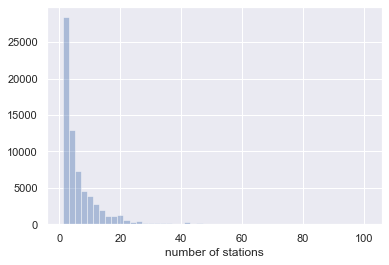

In [43]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### The number of stations that reported Snow data (non-NaN stations per circle)

In [44]:
circle_data.num_notna.describe()

count    68390.000000
mean         0.678096
std          0.841609
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         23.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

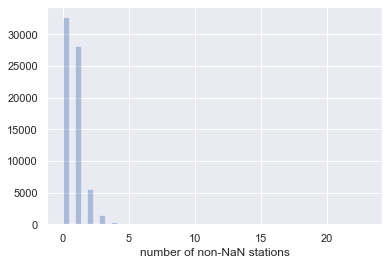

In [45]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("number of non-NaN stations")

## Missing Stations

Text(0.5, 1.0, 'cumulative percent of stations missing')

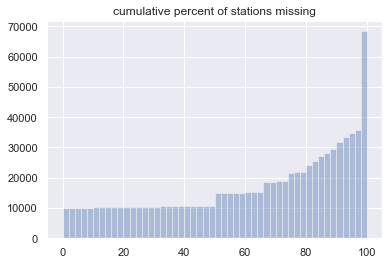

In [46]:
# Plot the number of stations (y-axis) agiast the proportion of stations missing snowdepth data (x-axis)
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')


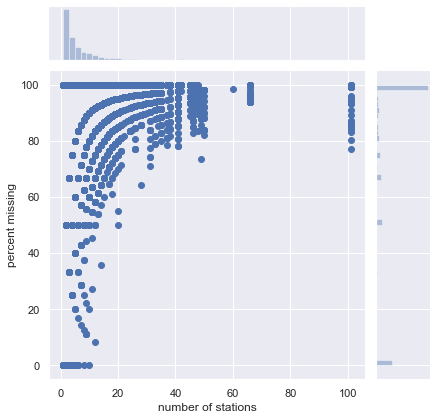

In [47]:
# Plot the relationship between the nuber of stations and the proportion of stations missing snowdepth data
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

#### Percent of circles where all stations are missing data

In [48]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

47.85787395818102

In [49]:
circle_data.c_snwd.value_counts(dropna = False)

False    32813
True     21082
NaN      14495
Name: c_snwd, dtype: int64

#### Percent of circles where no stations are missing data

In [50]:
((circle_data.num_notna == circle_data.num) & (circle_data.num > 0)).sum() / len(circle_data) * 100

14.870595116245063

#### Percent of circles with less than half of stations missing ( Over half the stations reporting Snow Data

In [51]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

21.665448164936393

## The number of stations per circle broken down by ecosystem
The two ecosystems calssification are ecosystem (as defined by usgs) and nlcd code

The prefixes "e_" and "n_", which is same ecosystem and same nlcd code, respectfully

In [52]:
# The breakdown of stations with the same nlcd code 
circle_data.n_num.describe()

count    68390.000000
mean         2.174675
std          3.956987
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: n_num, dtype: float64

In [53]:
# The breakdown of stations with the same ecosystem
circle_data.e_num.describe()

count    68390.000000
mean         1.517225
std          2.816323
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         26.000000
Name: e_num, dtype: float64

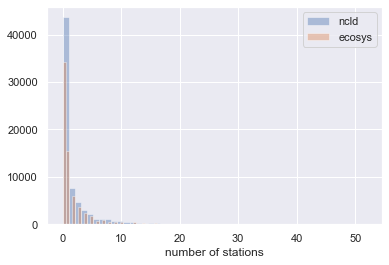

In [54]:
# The number of stations that share the same ncld or ecosys with their circle
sns.distplot(circle_data.n_num, kde=False)
ax = sns.distplot(circle_data.e_num, kde=False)
ax.set_xlabel("number of stations")
ax.legend(["ncld", "ecosys"])

### The number of stations with snow data in the same ecosystem classifical as the  circle

In [55]:
circle_data.n_num_notna.describe()

count    68390.000000
mean         0.371063
std          0.680166
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         23.000000
Name: n_num_notna, dtype: float64

In [56]:
circle_data.e_num_notna.describe()

count    68390.000000
mean         0.261851
std          0.553486
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: e_num_notna, dtype: float64

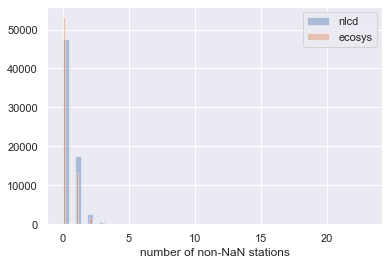

In [57]:
sns.distplot(circle_data.n_num_notna, kde=False)
ax = sns.distplot(circle_data.e_num_notna, kde=False)
ax.set_xlabel("number of non-NaN stations")
ax.legend(["nlcd", "ecosys"])

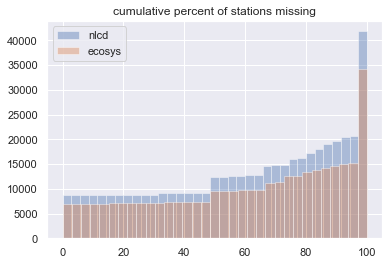

In [58]:
sns.distplot((1 - circle_data.n_num_notna/circle_data.n_num) * 100, kde=False, hist_kws={'cumulative': True})
ax = sns.distplot((1 - circle_data.e_num_notna/circle_data.e_num) * 100, kde=False, hist_kws={'cumulative': True})
ax.set_title('cumulative percent of stations missing')
ax.legend(["nlcd", "ecosys"])

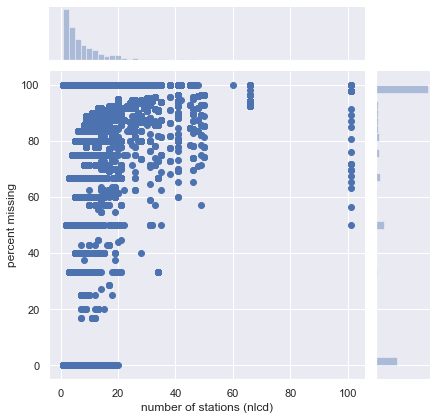

In [59]:
sns.jointplot(circle_data.num, (1 - circle_data.n_num_notna/circle_data.n_num) * 100).set_axis_labels("number of stations (nlcd)", 'percent missing')

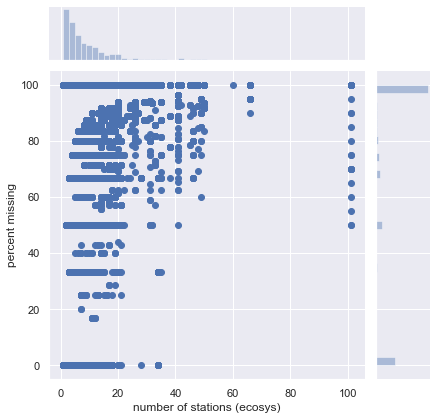

In [60]:
sns.jointplot(circle_data.num, (1 - circle_data.e_num_notna/circle_data.e_num) * 100).set_axis_labels("number of stations (ecosys)", 'percent missing')

#### Percent of circles where all stations are missing data

In [61]:
(circle_data.n_num_notna == 0).sum() / len(circle_data) * 100

69.67831554320807

In [62]:
(circle_data.e_num_notna == 0).sum() / len(circle_data) * 100

77.72335136715894

#### Percent of circles where no stations are missing data

In [63]:
((circle_data.n_num_notna == circle_data.n_num) & (circle_data.n_num > 0)).sum() / len(circle_data) * 100

12.776721742944874

In [64]:
((circle_data.e_num_notna == circle_data.e_num) & (circle_data.e_num > 0)).sum() / len(circle_data) * 100

10.270507384120485

#### Percent of circles with less than half of stations missing

In [65]:
((circle_data.n_num_notna / circle_data.n_num) >= 0.5).sum() / len(circle_data) * 100

18.24535750840766

In [66]:
((circle_data.e_num_notna / circle_data.e_num) >= 0.5).sum() / len(circle_data) * 100

14.042988741044013

## Location, Location, Location
The next section will focus in on the stations closest to the cbc circles by distance

#### What percent of circles had the closest station as NaN?

In [67]:
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

74.84573768094751

#### What percent had the average value of the reference stations differ from the closest station's value (ignoring NaNs)?

In [68]:
# Use kleene logical indexing to skip over NAs
(circle_data.snow_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.013159818686942536

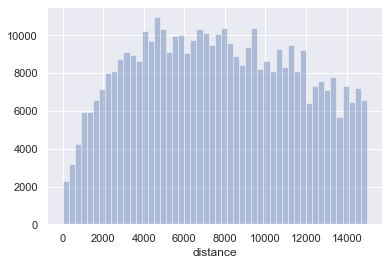

In [69]:
sns.distplot(prcp_data.distance, kde=False)

## Elevation, Elevation, Elevation
The next section will look at stations with the closest elivation

#### What percent of circles had the lowest station as NaN?

In [70]:
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

74.98757128235121

#### What percent had the average value differ from the lowest value (ignoring NaNs)?

In [71]:
# Use kleene logical indexing to skip over NAs
(circle_data.snow_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.013159818686942536

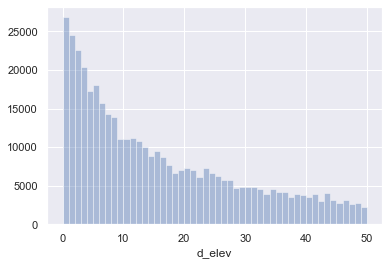

In [72]:
sns.distplot(prcp_data.d_elev, kde=False)

## Consensus of Stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for snow)

### All Stations

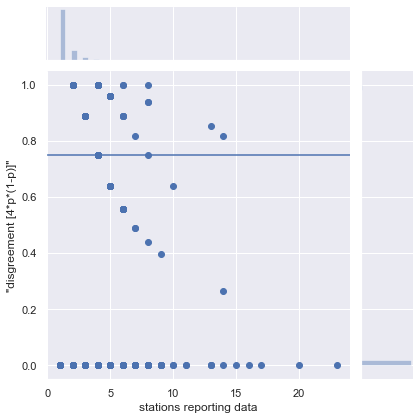

In [73]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [74]:
# Breaking this down a bit for easy of readability 

# circle_data.consensus is na when p (the proportion of staions for a circle reporting snowdepth) is NA OR p is not 
# meeting the AGREEMENT Threshold 

# circle_data.p is NOT na when a circle has at least one station reporting snowdepth data 

# PUTTING IT TOGETHER - The below line counts the number of station who had at least one station reporting 
# but did not meet the agreement threshold
(circle_data.consensus.isna() & circle_data.p.notna()).sum() / len(circle_data) * 100

0.991373007749671

### Ecosystems

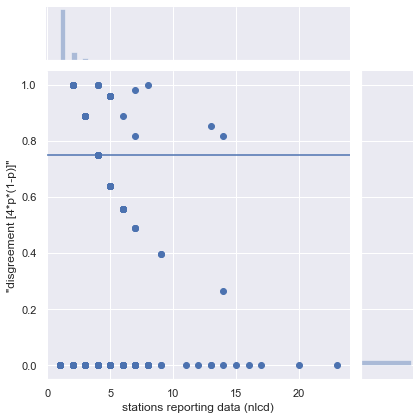

In [75]:
# Agreement Plot for Stations that share ncld codes with their circles 
p = sns.jointplot(circle_data.n_num_notna, 4 * circle_data.n_p * (1 - circle_data.n_p))
p.set_axis_labels("stations reporting data (nlcd)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

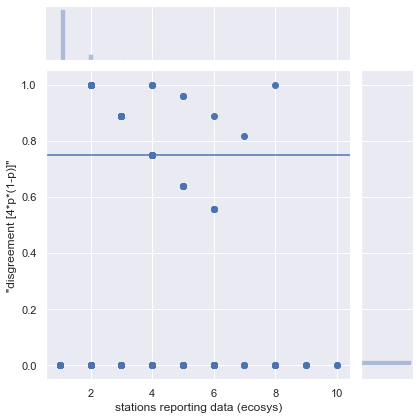

In [76]:
# Agreement Plot for Stations that share ecosys classification with their circles 
p = sns.jointplot(circle_data.e_num_notna, 4 * circle_data.e_p * (1 - circle_data.e_p))
p.set_axis_labels("stations reporting data (ecosys)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

#### What percent do not meet our dissagreement threshold?

In [77]:
# The below line counts the number of stations who had at least one station reporting with the same nlcd code
# but did not meet the agreement threshold
(circle_data.n_consensus.isna() & circle_data.n_p.notna()).sum() / len(circle_data) * 100

0.3904079543792952

In [78]:
# The below line counts the number of stations who had at least one station reporting with the same ecosys classifier
# but did not meet the agreement threshold
(circle_data.e_consensus.isna() & circle_data.e_p.notna()).sum() / len(circle_data) * 100

0.24857435297558125

### Consensus Breakdown by Circle Snow Depth Reporting

In [79]:
# The number and percentage  of circles that reported Snow, No Snow or are NA 
print("The Count of Circles Reproting Snow:")
print(circle_data.c_snwd.value_counts(dropna = False))
print("The Percentage of Circles Reproting Snow:")
print(circle_data.c_snwd.value_counts(dropna = False, normalize = True) * 100)


The Count of Circles Reproting Snow:
False    32813
True     21082
NaN      14495
Name: c_snwd, dtype: int64
The Percentage of Circles Reproting Snow:
False    47.979237
True     30.826144
NaN      21.194619
Name: c_snwd, dtype: float64


#### Break Down of Concensus for Circles that reported True for Snow Depth

In [80]:

print("Snow Data Consensus Amoung All Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snwd'] == True].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == True].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == True]) * 100))

print("Snow Data Consensus Amoung Closest Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snwd'] == True].snow_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == True].snow_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == True]) * 100))

print("Snow Data Consensus Amoung Closest in Elivation Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snwd'] == True].snow_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == True].snow_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snwd'] == True].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == True].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snwd'] == True].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == True].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == True]) * 100))




Snow Data Consensus Amoung All Stations where the Circle Reported Snow:
NaN      11327
True      6893
False     2862
Name: consensus, dtype: Int64
^^ with Percentage:
NaN      53.728299
True     32.696139
False    13.575562
Name: consensus, dtype: float64
Snow Data Consensus Amoung Closest Stations where the Circle Reported Snow:
NaN      17167
True      2732
False     1183
Name: snow_closest, dtype: Int64
^^ with Percentage:
NaN      81.429656
True     12.958922
False     5.611422
Name: snow_closest, dtype: float64
Snow Data Consensus Amoung Closest in Elivation Stations where the Circle Reported Snow:
NaN      17324
True      2666
False     1092
Name: snow_lowest, dtype: Int64
^^ with Percentage:
NaN      82.174367
True     12.645859
False     5.179774
Name: snow_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Snow:
NaN      15727
True      3794
False     1561
Name: n_consensus, dtype: Int64
^^ with Percentage:
NaN      74.

#### Break Down of Concensus for Circles that reported False for Snow Depth

In [81]:

print("Snow Data Consensus Amoung All Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snwd'] == False].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == False].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == False]) * 100))

print("Snow Data Consensus Amoung Closest Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snwd'] == False].snow_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == False].snow_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == False]) * 100))

print("Snow Data Consensus Amoung Closest in Elivation Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snwd'] == False].snow_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == False].snow_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == False]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snwd'] == False].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == False].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == False]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snwd'] == False].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snwd'] == False].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snwd'] == False]) * 100))




Snow Data Consensus Amoung All Stations where the Circle did NOT Report Snow:
NaN      17124
False    15197
True       492
Name: consensus, dtype: Int64
^^ with Percentage:
NaN      52.186633
False    46.313961
True      1.499406
Name: consensus, dtype: float64
Snow Data Consensus Amoung Closest Stations where the Circle did NOT Report Snow:
NaN      27926
False     4730
True       157
Name: snow_closest, dtype: Int64
^^ with Percentage:
NaN      85.106513
False    14.415018
True      0.478469
Name: snow_closest, dtype: float64
Snow Data Consensus Amoung Closest in Elivation Stations where the Circle did NOT Report Snow:
NaN      27926
False     4721
True       166
Name: snow_lowest, dtype: Int64
^^ with Percentage:
NaN      85.106513
False    14.387590
True      0.505897
Name: snow_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Snow:
NaN      22831
False     9659
True       323
Name: n_consensus, dtype: Int64
^^ with 

## The Missing Station and Circle Data

In [82]:
# Create a series indicating if a circle is missing weather data
circle_data_na_circle_idx = circle_data.c_snwd.isna()

### Percent of circles with missing snow observation

In [83]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

21.194619096359116

### Count of circles with missing snow observation

In [84]:
print("Circles with missing Snow Data: ")
print(circle_data_na_circle_idx.sum())
print("Circles with NO missing Snow Data: ")
print(len(circle_data) - circle_data_na_circle_idx.sum())

Circles with missing Snow Data: 
14495
Circles with NO missing Snow Data: 
53895


### Percent of circles with both volunteer and all station data are missing

In [85]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

7.03904079543793

In [86]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

33.211452224905145

In [87]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

47.85787395818102

## Correlation between the two

In [88]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(1580.4424649341222, 0.0)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

#### Count and Percent of Stations Reporting if the Circle Reported Snow Data

In [89]:
print("Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Stations with missing Snow Data IF the the Circle is Reporting:
27916
51.79701270989888
Stations with NO missing Snow Data IF the Circle is Reporting: 
25979
48.20298729010112


### Percent of circles with both volunteer and the closest station data are missing

In [90]:
# joint
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum()  / len(circle_data) * 100

8.910659453136423

In [91]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

42.042083477061055

In [92]:
# population
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

74.84573768094751

In [93]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_closest.isna()))
g, p

(10510.824811273156, 0.0)

if the circle is missing data, it is much **less** likely that the closest station will have missing data, when compared to the general population

#### Count and Percent of Closest Stations Reporting if the Circle Reported Snow Data

In [94]:
print("Closest Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Stations with missing Snow Data IF the the Circle is Reporting:
45093
83.66824380740329
Closest Stations with NO missing Snow Data IF the Circle is Reporting: 
8802
16.331756192596718


### Percent of circles with both volunteer and the lowest station data are missing

In [95]:
# joint
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum()  / len(circle_data) * 100

8.822927328556807

In [96]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

41.62814763711625

In [97]:
# population
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

74.98757128235121

In [98]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_lowest.isna()))
g, p

(10910.997427924101, 0.0)

if the circle is missing data, it is much **less** likely that the lowest station will have missing data, when compared to the general population

#### Count and Percent of Closest Elivation Stations Reporting if the Circle Reported Snow Depth Data

In [99]:
print("Closest Elivation Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Elivation Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Elivation Stations with missing Snow Data IF the the Circle is Reporting:
45250
83.95955097875498
Closest Elivation Stations with NO missing Snow Data IF the Circle is Reporting: 
8645
16.040449021245013


### Number of stations for circles with missing data

In [100]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(1630.1469055414525, 0.0)

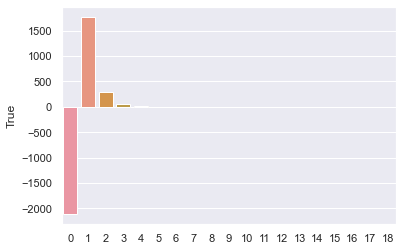

In [101]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### Disagreement

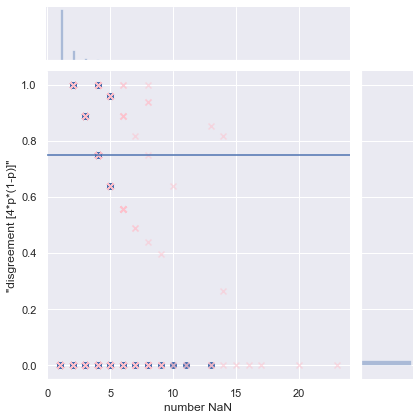

In [102]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [103]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

7.248135692352683

In [104]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

34.19799931010694

In [105]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

48.84924696593069

In [106]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(1579.4181990163775, 0.0)

In [107]:
actl - expctd

consensus,False,True
c_snwd,,
False,-2123.698348,2123.698348
True,2123.698348,-2123.698348


Missing your snow data imples the stations are more likely to consense

# The Truth: Reference Station Vs Reference Station

Get a feel for all the different precipitation measures to see if we can trust the NOAA stations as our source of truth

How often does it snow?

In [108]:
circle_data.consensus.sum()/ circle_data.consensus.count()

0.2836887542164542

### Location & Consensus

In [109]:
# Cross tabs of the closest station to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.snow_closest_notna)

snow_closest_notna,False,True
consensus,,
False,25052,6
True,3,9921


In [110]:
# Cross tabs of the closest station in elivation to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
consensus,,
False,24951,7
True,2,9869


In [111]:
# Cross tabs of the closest station to a circle vs the station with the closest elivation
pd.crosstab(circle_data.snow_closest_notna, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
snow_closest_notna,,
False,25161,125
True,138,10078


### Ecosystem Consensus

In [112]:
# Crosstable of stations with consensus vs stations with nlcd consensus 
pd.crosstab(circle_data.consensus, circle_data.n_consensus)

n_consensus,False,True
consensus,,
False,14973,0
True,0,5301


In [113]:
# Crosstabs  of stations with consensus vs stations with ecosys consensus
pd.crosstab(circle_data.consensus, circle_data.e_consensus)

e_consensus,False,True
consensus,,
False,10953,1
True,1,3912


In [114]:
pd.crosstab(circle_data.n_consensus, circle_data.e_consensus)

e_consensus,False,True
n_consensus,,
False,11004,0
True,0,4006


### We only need one:
If we just had one station per circle, how accurate is that?

In [115]:
# Cross tabes of the snowdepth reported by the closest station and if any reference station said it accumulated snow
pd.crosstab(circle_data.snow_closest_notna, circle_data.num_true > 0)

num_true,False,True
snow_closest_notna,,
False,25045,345
True,0,10270


In [116]:
# Crosstabs of the snowdepth reported by the closest station in elivation and if any reference station said it accumulated snow
pd.crosstab(circle_data.snow_lowest_notna, circle_data.num_true > 0)

num_true,False,True
snow_lowest_notna,,
False,24945,354
True,0,10203


In [117]:
# Crosstabs of the stations resporting consensus vs ANY reference station that reported accumulated snow
pd.crosstab(circle_data.consensus, circle_data.num_true > 0)

num_true,False,True
consensus,,
False,25045,13
True,0,9924


In [118]:
# Crosstabs of the stations resporting consensus vs ANY NLCD MATCHING reference station that reported accumulated snow
pd.crosstab(circle_data.consensus, circle_data.n_num_true > 0)

n_num_true,False,True
consensus,,
False,25049,9
True,4619,5305


In [119]:
# Crosstabs of the stations resporting consensus vs ANY ECOSYS MATCHING reference station that reported accumulated snow
pd.crosstab(circle_data.consensus, circle_data.e_num_true > 0)

e_num_true,False,True
consensus,,
False,25051,7
True,6010,3914


# Circle v Station: The Final Determination on If Volenteers are Reliable

In [120]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### Based on the stations' consensus

In [121]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_snwd)
actl

c_snwd,False,True
consensus,,
False,15197,2862
True,492,6893


In [122]:
crosstab_metrics(actl)

accuracy:  86.82%
precision: 70.66%
recall:    93.34%
F1:        80.43%


### Based on the closest station

In [123]:
actl = pd.crosstab(circle_data.snow_closest_notna, circle_data.c_snwd)
actl

c_snwd,False,True
snow_closest_notna,,
False,15250,3073
True,556,7100


In [124]:
crosstab_metrics(actl)

accuracy:  86.03%
precision: 69.79%
recall:    92.74%
F1:        79.65%


### Based on the closest station in elivation

In [125]:
actl = pd.crosstab(circle_data.snow_lowest_notna, circle_data.c_snwd)
actl

c_snwd,False,True
snow_lowest_notna,,
False,15217,3012
True,542,7072


In [126]:
crosstab_metrics(actl)

accuracy:  86.25%
precision: 70.13%
recall:    92.88%
F1:        79.92%


### Based on the nlcd consensus

In [127]:
actl = pd.crosstab(circle_data.n_consensus, circle_data.c_snwd)
actl

c_snwd,False,True
n_consensus,,
False,9659,1561
True,323,3794


In [128]:
crosstab_metrics(actl)

accuracy:  87.72%
precision: 70.85%
recall:    92.15%
F1:        80.11%


### Based on the ecosys consensus

In [129]:
actl = pd.crosstab(circle_data.e_consensus, circle_data.c_snwd)
actl

c_snwd,False,True
e_consensus,,
False,7104,1217
True,240,2848


In [130]:
crosstab_metrics(actl)

accuracy:  87.23%
precision: 70.06%
recall:    92.23%
F1:        79.63%


### Did at least one station aggree?

In [131]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_snwd)
actl

c_snwd,False,True
num_true,,
False,32200,13763
True,613,7319


In [132]:
crosstab_metrics(actl)

accuracy:  73.33%
precision: 34.72%
recall:    92.27%
F1:        50.45%
